In [125]:
using MagneticLaplacianSparsifier
using Graphs, MetaGraphs, Random, IterTools, LinearAlgebra, GraphPlot, Arpack, Plots, SparseArrays
using Statistics
using Measures
using StatsBase#, JLD
using PlotlyJS

### Performance of the algebraic sampler of HKPV
1. [MUN graph  with $\eta$ small](#graph_small_eta)<br />
    1.2 [Sampling several times CRSFs with cycle popping and HKPV with $\eta$ small](#sampling_small_eta) <br />
    1.3 [Distributions of cycle-rooted trees with $\eta$ small](#CTRs_small_eta) <br />
    1.4 [Distributions of connected subgraphs with $0$ cycles (trees) with $\eta$ small ](#Ts_small_eta) <br />
    1.5 [Distributions of connected subgraphs with at least $2$ cycles with $\eta$ small](#Morecycles_small_eta) <br />
    1.6 [Timings with $\eta$ small](#Timing_small_eta) <br />
2. [MUN graph  with $\eta$ large](#graph_large_eta)<br />
    1.2 [Sampling several times CRSFs with cycle popping and HKPV with $\eta$ large](#sampling_large_eta) <br />
    1.3 [Distributions of cycle-rooted trees with $\eta$ large](#CTRs_large_eta) <br />
    1.4 [Distributions of connected subgraphs with $0$ cycles (trees) with $\eta$ large](#Ts_large_eta) <br />
    1.5 [Distributions of connected subgraphs with at least $2$ cycles with $\eta$ large](#Morecycles_large_eta) <br />
    1.6 [Timings with $\eta$ large](#Timing_large_eta) <br />

#### 1. MUN graph  with $\eta$ small <a name="graph_small_eta"></a>


In [160]:
type="MUN"

rng = Random.default_rng()

# graph parameters
n = 100
p = 0.2
eta = 0.7 # 1e-3

# planted ranking score
planted_score = randperm(rng,n)

# graph model
if type=="MUN"
    meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
elseif type=="ERO"
    meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
end

sparseB = sp_magnetic_incidence(meta_g; oriented=true);

1.1 Sampling several times CRSFs with cycle popping and HKPV  with $\eta$ small <a name="sampling_small_eta"></a>


In [161]:
n = nv(meta_g)

nb_samples = 50

nb_edges = zeros(nb_samples)
nb_cc = zeros(nb_samples)

cc_with_1_cycle = zeros(nb_samples)
cc_with_0_cycle = zeros(nb_samples)
cc_with_more_than_1_cycle = zeros(nb_samples)


time_hkpv = zeros(nb_samples)
time_mtsf = zeros(nb_samples)


V = Matrix(qr(Matrix(sparseB)).Q)

for i_sample in 1:nb_samples

    id, t = @timed sample_pdpp(V)
    e = collect(edges(meta_g))
    subgraph,_ = induced_subgraph(meta_g, e[id])

    nb_edges[i_sample] = ne(subgraph)
    cc = connected_components(subgraph)

    nb_cc[i_sample] = length(cc)

    cc = [induced_subgraph(subgraph, cc)[1] for cc in connected_components(subgraph)]

    temp_cc_with_1_cycle = 0
    temp_cc_with_0_cycle = 0
    temp_cc_with_more_than_1_cycle = 0

    for i in cc
        l = length(cycle_basis(i))
        if l == 1
            temp_cc_with_1_cycle += 1
        elseif l == 0
            temp_cc_with_0_cycle += 1
        else
            temp_cc_with_more_than_1_cycle += 1
        end
    end

    cc_with_1_cycle[i_sample] = temp_cc_with_1_cycle
    cc_with_0_cycle[i_sample] = temp_cc_with_0_cycle
    cc_with_more_than_1_cycle[i_sample] = temp_cc_with_more_than_1_cycle

    time_hkpv[i_sample] = t
    mtsf, t_mtsf = @timed multi_type_spanning_forest(rng, meta_g, q)
    time_mtsf[i_sample] = t_mtsf

end    

println(cc_with_1_cycle)
println(cc_with_0_cycle)
println(cc_with_more_than_1_cycle)
#println(nb_cc)
println(" ")
println([mean(time_hkpv) mean(time_mtsf)])

[1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 3.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 2.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 3.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0]
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]
 
[0.008414664919999999 0.00024990468]


1.2 Distributions of cycle-rooted trees  with $\eta$ small <a name="CTRs_small_eta"></a>


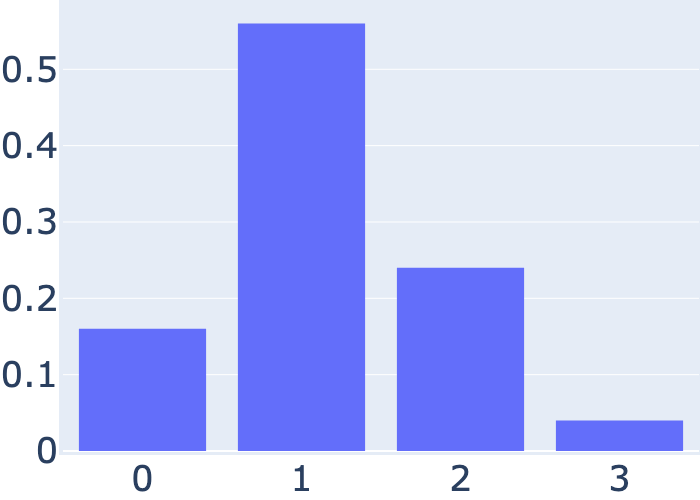

In [162]:
cat_nb_cc_1_cycle = string.(sort(Int.(cc_with_1_cycle)))
trace = PlotlyJS.histogram(x=cat_nb_cc_1_cycle, histnorm="probability density")
layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=35,
    xaxis_type="category",
)
p_1 = PlotlyJS.plot(trace,layout)

1.3 Distributions of connected subgraphs with $0$ cycles (trees) with $\eta$ small <a name="Ts_small_eta"></a>


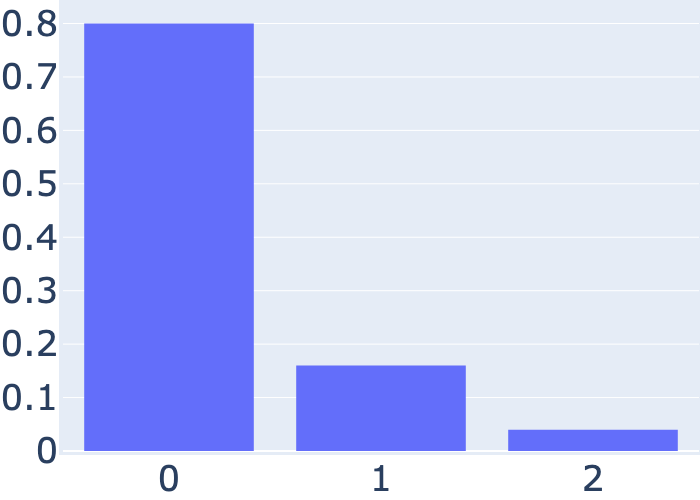

In [163]:
cat_nb_cc_0_cycle = string.(sort(Int.(cc_with_0_cycle)))
trace = PlotlyJS.histogram(x=cat_nb_cc_0_cycle, histnorm="probability density")
layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=35,
    xaxis_type="category",
)
p_0 = PlotlyJS.plot(trace,layout)

1.4 Distributions of connected subgraphs with at least $2$ cycles with $\eta$ small <a name="Morecycles_small_eta"></a>

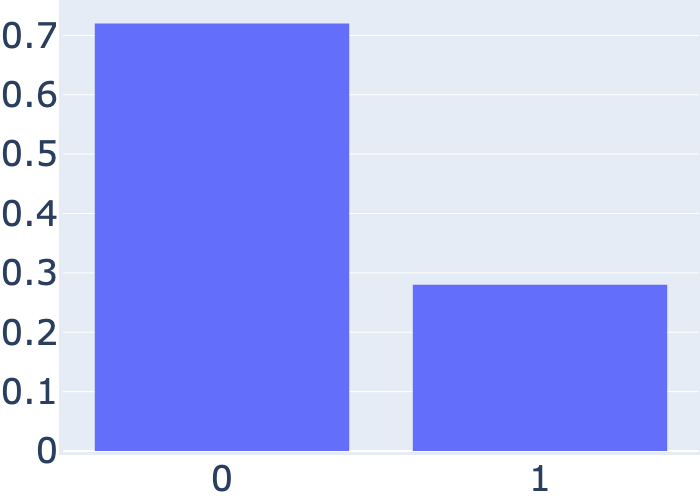

In [164]:
cat_nb_cc_with_more_than_1_cycle = string.(sort(Int.(cc_with_more_than_1_cycle
)))
trace = PlotlyJS.histogram(x=cat_nb_cc_with_more_than_1_cycle, histnorm="probability density")
layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=35,
    xaxis_type="category",
)
p_more_than_1 = PlotlyJS.plot(trace,layout)

1.5 Timings with $\eta$ small <a name="Timing_small_eta"></a>


HKPV timing

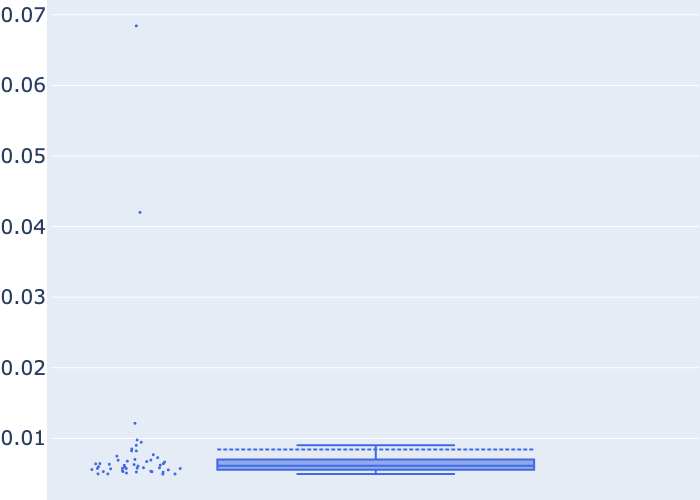

In [165]:
trace = box(y=(time_hkpv),
boxpoints="all",
marker=attr(
        color="LightSkyBlue",
        size=3),
quartilemethod="linear",
name="",
marker_color="royalblue",
boxmean=true)

layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=20,
)
p_time_hkpv = PlotlyJS.plot(trace,layout)

cycle popping timing

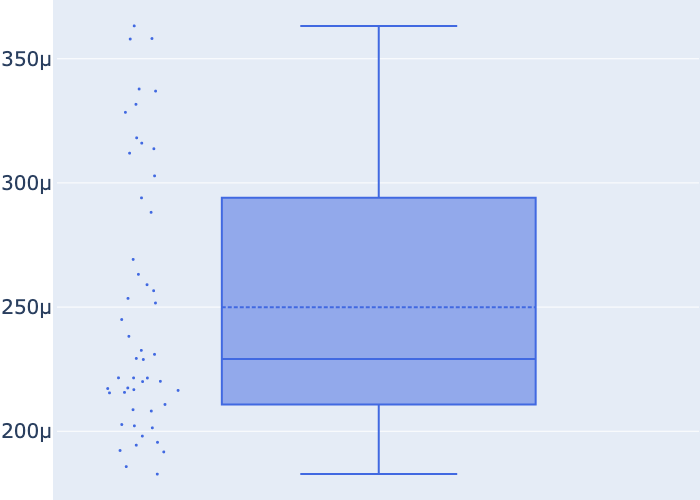

In [166]:
trace = box(y=(time_mtsf),
boxpoints="all",
marker=attr(
        color="LightSkyBlue",
        size=3),
quartilemethod="linear",
name="",
marker_color="royalblue",
boxmean=true)

layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=20,
)
p_time_hkpv = PlotlyJS.plot(trace,layout)

### 2. MUN graph  with $\eta$ large <a name="graph_large_eta"></a>


In [ ]:
type="MUN"

rng = Random.default_rng()

# graph parameters
n = 100
p = 0.2
eta = 

# planted ranking score
planted_score = randperm(rng,n)

# graph model
if type=="MUN"
    meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
elseif type=="ERO"
    meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
end

sparseB = sp_magnetic_incidence(meta_g; oriented=true);

2.1 Sampling several times CRSFs with cycle popping and HKPV with $\eta$ large <a name="sampling_large_eta"></a>


2.2 Distributions of cycle-rooted trees with $\eta$ large <a name="CTRs_large_eta"></a>


2.3 Distributions of connected subgraphs with $0$ cycles (trees) with $\eta$ large <a name="Ts_large_eta"></a>


2.4 Distributions of connected subgraphs with at least $2$ cycles with $\eta$ large <a name="Morecycles_large_eta"></a>


2.5 Timings with $\eta$ large <a name="Timing_large_eta"></a>
